In [1]:
import re
import pandas as pd
from collections import defaultdict
import operator
from pprint import pprint

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
books = ["data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt",
         "data/Rowling, J.K. - HP 2 - Harry Potter and the Chamber of Secrets.txt",
         "data/Rowling, J.K. - HP 3 - Harry Potter and the Prisoner of Azkaban.txt",
         "data/Rowling, J.K. - HP 4 - Harry Potter and the Goblet of Fire.txt",
         "data/Rowling, J.K. - HP 5 - Harry Potter and the Order of the Phoenix.txt",
         "data/Rowling, J.K. - HP 6 - Harry Potter and the Half-Blood Prince.txt",
         "data/Rowling, J.K. - HP 7 - Harry Potter and the Deathly Hallows.txt"]

In [3]:
pattern = ("(C H A P T E R [A-Z -]+)\n+" +           # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                     # chapter title ends before lowercase letters or a period
           "(.*?)" +                                 # Group 3 selects the chapter contents
           "(?=C H A P T E R|This book)")            # chapter contents ends with a new chapter or the end of book
hp = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read().replace('&rsquo;',"'")
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&ldquo;', '"')
                                   .replace('&rdquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\n+', '\n', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)

### The format of the Harry Potter hp dictionary is as follows:
&nbsp;   
{book 1 title: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'book 2 title': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [4]:
# Word Count
for book in hp:
    print('{:,} words in {}'.format(sum(len(hp[book][chapter][1].split()) for chapter in hp[book]), book))
print()    
print('{:,} total words in collection'.format(sum(len(hp[book][chapter][1].split())
                                                for book in hp
                                                for chapter in hp[book])))

79,210 words in Harry Potter and the Sorcerer's Stone
83,586 words in Harry Potter and the Chamber of Secrets
111,361 words in Harry Potter and the Prisoner of Azkaban
193,141 words in Harry Potter and the Goblet of Fire
250,099 words in Harry Potter and the Order of the Phoenix
168,946 words in Harry Potter and the Half-Blood Prince
193,529 words in Harry Potter and the Deathly Hallows

1,079,872 total words in collection


In [5]:
# Average word length
for book in hp:
    text = ''
    for chapter in hp[book]:
        text = text + hp[book][chapter][1]
    print('{:.2f} Average word length in {}'.format(len(text) / len(text.split()), book))

5.55 Average word length in Harry Potter and the Sorcerer's Stone
5.64 Average word length in Harry Potter and the Chamber of Secrets
5.64 Average word length in Harry Potter and the Prisoner of Azkaban
5.61 Average word length in Harry Potter and the Goblet of Fire
5.64 Average word length in Harry Potter and the Order of the Phoenix
5.67 Average word length in Harry Potter and the Half-Blood Prince
5.66 Average word length in Harry Potter and the Deathly Hallows


In [6]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [7]:
# Convert to list
data = [hp[book][chapter][1].replace('\n', '') for book in hp for chapter in hp[book]]
print(data[1])

Nearly ten years had passed since the Dursleys had woken up to find their nephew on the front step, but Privet Drive had hardly changed at all. The sun rose on the same tidy front gardens and lit up the brass number four on the Dursleys' front door; it crept into their living room, which was almost exactly the same as it had been on the night when Mr. Dursley had seen that fateful news report about the owls. Only the photographs on the mantelpiece really showed how much time had passed. Ten years ago, there had been lots of pictures of what looked like a large pink beach ball wearing different-colored bonnets — but Dudley Dursley was no longer a baby, and now the photographs showed a large blond boy riding his first bicycle, on a carousel at the fair, playing a computer game with his father, being hugged and kissed by his mother. The room held no sign at all that another boy lived in the house, too. Yet Harry Potter was still there, asleep at the moment, but not for long. His Aunt Petu

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'you', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didn', 'hold', 'with', 'such', 'nonsense', 'mr', 'dursley', 'was', 'the', 'director', 'of', 'firm', 'called', 'grunnings', 'which', 'made', 'drills', 'he', 'was', 'big', 'beefy', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'very', 'large', 'mustache', 'mrs', 'dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'craning', 'over', 'garden', 'fences', 'spying', 'on', 'the', 'neighbors', 'the', 'dursleys', 'had', 'small', 'son', 'called', 'dudley', 'and', 'in', 'the

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['mr', 'and', 'mrs_dursley', 'of', 'number_four', 'privet_drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'you', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didn', 'hold', 'with', 'such', 'nonsense', 'mr_dursley', 'was', 'the', 'director', 'of', 'firm', 'called', 'grunnings', 'which', 'made', 'drills', 'he', 'was', 'big', 'beefy', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'very', 'large', 'mustache', 'mrs_dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so', 'much', 'of', 'her', 'time', 'craning', 'over', 'garden', 'fences', 'spying', 'on', 'the', 'neighbors', 'the', 'dursleys', 'had', 'small', 'son', 'called', 'dudley', 'and', 'in', 'their', 'opinion', 

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc])# if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['mr', 'mrs', 'dursley', 'number', 'four', 'privet_drive', 'proud', 'say', 'perfectly', 'normal', 'thank', 'much', 'last', 'people', 'expect', 'involve', 'anything', 'strange', 'mysterious', 'hold', 'nonsense', 'mr', 'dursley', 'director', 'firm', 'call', 'grunning', 'make', 'drill', 'big', 'beefy', 'man', 'hardly', 'neck', 'although', 'large', 'mustache', 'mrs', 'dursley', 'thin', 'blonde', 'nearly', 'twice', 'usual', 'amount', 'neck', 'come', 'useful', 'spend', 'much', 'time', 'crane', 'garden', 'fence', 'spy', 'neighbor', 'dursley', 'small', 'son', 'call', 'dudley', 'opinion', 'fine', 'boy', 'anywhere', 'dursley', 'everything', 'want', 'also', 'secret', 'great', 'fear', 'somebody', 'would', 'discover', 'think', 'could', 'bear', 'anyone', 'find', 'potter', 'mrs', 'potter', 'mrs', 'dursley', 'sister', 'meet', 'several', 'year', 'fact', 'mrs', 'dursley', 'pretend', 'sister', 'sister', 'good', 'nothing', 'husband', 'undursleyish', 'possible', 'dursley', 'shudder', 'think', 'neighbor', 

In [12]:
print(data_lemmatized[19])

['ron', 'breathe', 'harry', 'creep', 'window', 'pushing', 'could', 'talk', 'bar', 'ron', 'harry', 'mouth', 'fall', 'open', 'full', 'impact', 'see', 'hit', 'ron', 'lean', 'back', 'window', 'old', 'turquoise', 'car', 'park', 'midair', 'grin', 'harry', 'front', 'seat', 'fr', 'george', 'ron', 'eld', 'twin', 'brother', 'right', 'harry', 'ask', 'george', 'go', 'say', 'ron', 'answering', 'letter', 'ask', 'stay', 'twelve', 'time', 'dad', 'come', 'home', 'say', 'get', 'official', 'warning', 'use', 'magic', 'front', 'muggle', 'know', 'work', 'ministry', 'say', 'ron', 'know', 'suppose', 'spell', 'outside', 'school', 'talk', 'say', 'harry', 'star', 'float', 'car', 'oh', 'count', 'say', 'ron', 'borrow', 'dad', 'enchant', 'magic', 'front', 'muggle', 'live', 'tell', 'take', 'long', 'explain', 'look', 'tell', 'hogwart', 'dursley', 'lock', 'let', 'come', 'back', 'obviously', 'magic', 'ministry', 'think', 'second', 'spell', 'do', 'three', 'day', 'stop', 'gibber', 'say', 'ron', 'come', 'take', 'home', '-

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 2), (2, 2), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 3), (11, 2), (12, 5), (13, 2), (14, 2), (15, 2), (16, 1), (17, 1), (18, 2), (19, 1), (20, 3), (21, 1), (22, 1), (23, 2), (24, 5), (25, 1), (26, 1), (27, 2), (28, 1), (29, 3), (30, 1), (31, 10), (32, 3), (33, 3), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 4), (40, 2), (41, 15), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 3), (49, 2), (50, 3), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 3), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 3), (65, 2), (66, 1), (67, 1), (68, 2), (69, 2), (70, 4), (71, 2), (72, 5), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 3), (82, 1), (83, 1), (84, 1), (85, 1), (86, 9), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 2), (93, 1), (94, 1), (95, 2), (96, 1), (97, 1), (98, 1), (99, 2), (100, 1), (101, 4), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 9), (108, 1), (109, 3), (110, 

In [14]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('-PRON-', 2),
  ('able', 2),
  ('across', 2),
  ('act', 2),
  ('admire', 1),
  ('affect', 1),
  ('afternoon', 1),
  ('age', 1),
  ('agree', 1),
  ('air', 3),
  ('albus', 3),
  ('allow', 2),
  ('almost', 5),
  ('also', 2),
  ('although', 2),
  ('always', 2),
  ('amount', 1),
  ('amuse', 1),
  ('angrily', 2),
  ('angry', 1),
  ('another', 3),
  ('answer', 1),
  ('anxious', 1),
  ('anyone', 2),
  ('anything', 5),
  ('anywhere', 1),
  ('apart', 1),
  ('appear', 2),
  ('approve', 1),
  ('arm', 3),
  ('armchair', 1),
  ('around', 10),
  ('arrive', 3),
  ('ask', 3),
  ('astonishing', 1),
  ('astounding', 1),
  ('astride', 1),
  ('aunt', 2),
  ('awake', 1),
  ('away', 4),
  ('baby', 2),
  ('back', 15),
  ('bag', 1),
  ('baker', 1),
  ('bakery', 1),
  ('ball', 1),
  ('bathroom', 1),
  ('beady', 1),
  ('bear', 3),
  ('beard', 2),
  ('bed', 3),
  ('bedroom', 1),
  ('beefy', 1),
  ('behave', 1),
  ('behavior', 1),
  ('behind', 1),
  ('believe', 3),
  ('belt', 1),
  ('bend', 1),
  ('beneath', 1)

In [15]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.025*"harry" + 0.022*"say" + 0.016*"dumbledore" + 0.009*"know" + '
  '0.008*"look" + 0.007*"could" + 0.006*"see" + 0.006*"think" + '
  '0.006*"hermione" + 0.006*"voldemort"'),
 (1,
  '0.039*"say" + 0.029*"harry" + 0.016*"ron" + 0.015*"hermione" + 0.012*"look" '
  '+ 0.010*"hagrid" + 0.009*"get" + 0.008*"go" + 0.007*"know" + 0.006*"see"'),
 (2,
  '0.039*"harry" + 0.022*"say" + 0.011*"ron" + 0.009*"look" + 0.009*"go" + '
  '0.009*"get" + 0.008*"see" + 0.007*"hermione" + 0.007*"back" + 0.006*"know"'),
 (3,
  '0.030*"harry" + 0.028*"say" + 0.015*"ron" + 0.011*"look" + 0.011*"hermione" '
  '+ 0.007*"get" + 0.006*"see" + 0.006*"snape" + 0.006*"think" + 0.006*"go"')]


In [17]:
# Compute Perplexity
print ('Perplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print ('Coherence Score: ', coherence_lda)

Perplexity:  -7.50514341386956
Coherence Score:  0.2662545693184638


In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [19]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [20]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('hermione', 0.09009193054136874),
   ('harry', 0.0752468505277494),
   ('ron', 0.0669390534559074),
   ('wand', 0.018522301668369084),
   ('make', 0.015798433775961865),
   ('goblin', 0.015526046986721144),
   ('sword', 0.012393598910452844),
   ('back', 0.011712631937351038),
   ('feel', 0.011508341845420498),
   ('place', 0.010146407899216888)]),
 (14,
  [('snape', 0.05596980994816768),
   ('professor_mcgonagall', 0.022688005819769028),
   ('neville', 0.020187323815586068),
   ('professor', 0.018186778212239702),
   ('gryffindor', 0.01409475311448577),
   ('student', 0.013867418386832772),
   ('malfoy', 0.011866872783486405),
   ('filch', 0.011775938892425206),
   ('corridor', 0.010866599981813222),
   ('goyle', 0.009502591615895244)]),
 (5,
  [('harry', 0.08235010835540572),
   ('dobby', 0.0353158359418894),
   ('kreacher', 0.024480295368809697),
   ('moody', 0.024078979051288224),
   ('sir', 0.018460550605987638),
   ('dumbledore', 0.01821976081547476),
   ('water', 0.016

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
# Can take a long time to run.
limit=35; start=2; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

Calculating 2-topic model
Calculating 4-topic model
Calculating 6-topic model
Calculating 8-topic model
Calculating 10-topic model
Calculating 12-topic model
Calculating 14-topic model
Calculating 16-topic model
Calculating 18-topic model
Calculating 20-topic model
Calculating 22-topic model
Calculating 24-topic model
Calculating 26-topic model
Calculating 28-topic model
Calculating 30-topic model
Calculating 32-topic model
Calculating 34-topic model


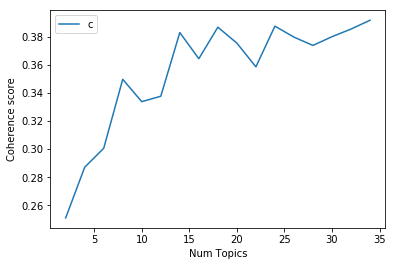

In [23]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 2  has Coherence Value of 0.251106
Num Topics = 4  has Coherence Value of 0.28714
Num Topics = 6  has Coherence Value of 0.300613
Num Topics = 8  has Coherence Value of 0.349632
Num Topics = 10  has Coherence Value of 0.333741
Num Topics = 12  has Coherence Value of 0.337601
Num Topics = 14  has Coherence Value of 0.382851
Num Topics = 16  has Coherence Value of 0.364288
Num Topics = 18  has Coherence Value of 0.386692
Num Topics = 20  has Coherence Value of 0.37537
Num Topics = 22  has Coherence Value of 0.358489
Num Topics = 24  has Coherence Value of 0.387439
Num Topics = 26  has Coherence Value of 0.379633
Num Topics = 28  has Coherence Value of 0.373729
Num Topics = 30  has Coherence Value of 0.379936
Num Topics = 32  has Coherence Value of 0.385357
Num Topics = 34  has Coherence Value of 0.391625


In [25]:
# Select the model and print the topics
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = 5
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.054*"harry" + 0.039*"ron" + 0.015*"malfoy" + 0.014*"gryffindor" + '
  '0.011*"snape" + 0.011*"slytherin" + 0.011*"hermione" + '
  '0.011*"professor_mcgonagall" + 0.009*"back" + 0.007*"time"'),
 (1,
  '0.036*"snape" + 0.035*"sirius" + 0.028*"harry" + 0.026*"lupin" + '
  '0.021*"black" + 0.014*"fudge" + 0.012*"dementor" + 0.010*"hear" + '
  '0.009*"office" + 0.009*"voice"'),
 (2,
  '0.013*"-PRON-" + 0.011*"lsquo" + 0.009*"dumbledore" + 0.008*"give" + '
  '0.007*"wizard" + 0.007*"good" + 0.007*"luna" + 0.006*"long" + '
  '0.005*"family" + 0.005*"story"'),
 (3,
  '0.075*"harry" + 0.020*"uncle_vernon" + 0.019*"dudley" + 0.013*"dursley" + '
  '0.012*"back" + 0.011*"letter" + 0.011*"owl" + 0.010*"aunt_petunia" + '
  '0.008*"make" + 0.008*"house"'),
 (4,
  '0.055*"harry" + 0.020*"moody" + 0.018*"dobby" + 0.012*"cedric" + '
  '0.011*"dumbledore" + 0.010*"eye" + 0.010*"krum" + 0.008*"back" + '
  '0.008*"bagman" + 0.008*"mr_crouch"'),
 (5,
  '0.065*"harry" + 0.043*"ron" + 0.024*"mrs_wea

In [26]:
optimal_model.show_topic(0,10)

[('harry', 0.053960603520536464),
 ('ron', 0.039213118189438394),
 ('malfoy', 0.014773679798826487),
 ('gryffindor', 0.013621123218776194),
 ('snape', 0.011499371332774518),
 ('slytherin', 0.01142078792958927),
 ('hermione', 0.011027870913663034),
 ('professor_mcgonagall', 0.01068734283319363),
 ('back', 0.009351424979044426),
 ('time', 0.007177284157585918)]

In [27]:
for topic in sorted(optimal_model.show_topics(num_words=10, formatted=False), key=lambda x: x[0]):
    print('Topic {}: {}'.format(topic[0], [item[0] for item in topic[1]]))

Topic 0: ['harry', 'ron', 'malfoy', 'gryffindor', 'snape', 'slytherin', 'hermione', 'professor_mcgonagall', 'back', 'time']
Topic 1: ['snape', 'sirius', 'harry', 'lupin', 'black', 'fudge', 'dementor', 'hear', 'office', 'voice']
Topic 2: ['-PRON-', 'lsquo', 'dumbledore', 'give', 'wizard', 'good', 'luna', 'long', 'family', 'story']
Topic 3: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'back', 'letter', 'owl', 'aunt_petunia', 'make', 'house']
Topic 4: ['harry', 'moody', 'dobby', 'cedric', 'dumbledore', 'eye', 'krum', 'back', 'bagman', 'mr_crouch']
Topic 5: ['harry', 'ron', 'mrs_weasley', 'mr_weasley', 'fr', 'george', 'ginny', 'back', 'percy', 'tonk']
Topic 6: ['door', 'open', 'sit', 'wizard', 'hogwart', 'stand', 'large', 'long', 'people', 'small']
Topic 7: ['harry', 'hermione', 'ron', 'umbridge', 'professor', 'make', 'good', 'neville', 'slughorn', 'malfoy']
Topic 8: ['harry', 'wand', 'back', 'foot', 'head', 'light', 'move', 'face', 'hand', 'shout']
Topic 9: ['hermione', 'harry', 'ron', 

In [28]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.3737,"harry, uncle_vernon, dudley, dursley, back, le...","Mr. and Mrs. Dursley, of number four, Privet D..."
1,1,3.0,0.5999,"harry, uncle_vernon, dudley, dursley, back, le...",Nearly ten years had passed since the Dursleys...
2,2,3.0,0.5759,"harry, uncle_vernon, dudley, dursley, back, le...",The escape of the Brazilian boa constrictor ea...
3,3,3.0,0.3087,"harry, uncle_vernon, dudley, dursley, back, le...",BOOM. They knocked again. Dudley jerked awake....
4,4,6.0,0.3654,"door, open, sit, wizard, hogwart, stand, large...",Harry woke early the next morning. Although he...
5,5,5.0,0.2711,"harry, ron, mrs_weasley, mr_weasley, fr, georg...",Harry's last month with the Dursleys wasn't fu...
6,6,0.0,0.3812,"harry, ron, malfoy, gryffindor, snape, slyther...","The door swung open at once. A tall, black-hai..."
7,7,7.0,0.2258,"harry, hermione, ron, umbridge, professor, mak...","There, look."" ""Where?"" ""Next to the tall kid w..."
8,8,0.0,0.4267,"harry, ron, malfoy, gryffindor, snape, slyther...",Harry had never believed he would meet a boy h...
9,9,0.0,0.4615,"harry, ron, malfoy, gryffindor, snape, slyther...",alfoy couldn't believe his eyes when he saw th...


In [29]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isin([0, 1])]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
6,6,0.0,0.3812,"harry, ron, malfoy, gryffindor, snape, slyther...","The door swung open at once. A tall, black-hai..."
8,8,0.0,0.4267,"harry, ron, malfoy, gryffindor, snape, slyther...",Harry had never believed he would meet a boy h...
9,9,0.0,0.4615,"harry, ron, malfoy, gryffindor, snape, slyther...",alfoy couldn't believe his eyes when he saw th...
10,10,0.0,0.5541,"harry, ron, malfoy, gryffindor, snape, slyther...","As they entered November, the weather turned v..."
11,11,0.0,0.2497,"harry, ron, malfoy, gryffindor, snape, slyther...",Christmas was coming. One morning in mid-Decem...
12,12,0.0,0.4569,"harry, ron, malfoy, gryffindor, snape, slyther...",Dumbledore had convinced Harry not to go looki...
16,16,0.0,0.2712,"harry, ron, malfoy, gryffindor, snape, slyther...","It was Quirrell. ""You!"" gasped Harry. Quirrel..."
22,22,0.0,0.2483,"harry, ron, malfoy, gryffindor, snape, slyther...","The next day, however, Harry barely grinned on..."
23,23,0.0,0.3833,"harry, ron, malfoy, gryffindor, snape, slyther...",Harry spent a lot of time over the next few da...
24,24,0.0,0.3455,"harry, ron, malfoy, gryffindor, snape, slyther...","October arrived, spreading a damp chill over t..."


In [30]:
[text.split() for text in df_dominant_topic['Keywords'].tolist()]

[['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'back,',
  'letter,',
  'owl,',
  'aunt_petunia,',
  'make,',
  'house'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'back,',
  'letter,',
  'owl,',
  'aunt_petunia,',
  'make,',
  'house'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'back,',
  'letter,',
  'owl,',
  'aunt_petunia,',
  'make,',
  'house'],
 ['harry,',
  'uncle_vernon,',
  'dudley,',
  'dursley,',
  'back,',
  'letter,',
  'owl,',
  'aunt_petunia,',
  'make,',
  'house'],
 ['door,',
  'open,',
  'sit,',
  'wizard,',
  'hogwart,',
  'stand,',
  'large,',
  'long,',
  'people,',
  'small'],
 ['harry,',
  'ron,',
  'mrs_weasley,',
  'mr_weasley,',
  'fr,',
  'george,',
  'ginny,',
  'back,',
  'percy,',
  'tonk'],
 ['harry,',
  'ron,',
  'malfoy,',
  'gryffindor,',
  'snape,',
  'slytherin,',
  'hermione,',
  'professor_mcgonagall,',
  'back,',
  'time'],
 ['harry,',
  'hermione,',
  'ron,',
  'umbridge,',
  'professor,',
  'make,

In [31]:
for idx, row in df_dominant_topic.iterrows():
    print('{}. Dominant keywords: {}'.format(row['Document_No'], row['Keywords'].split(', ')[:5]))

0. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'back']
1. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'back']
2. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'back']
3. Dominant keywords: ['harry', 'uncle_vernon', 'dudley', 'dursley', 'back']
4. Dominant keywords: ['door', 'open', 'sit', 'wizard', 'hogwart']
5. Dominant keywords: ['harry', 'ron', 'mrs_weasley', 'mr_weasley', 'fr']
6. Dominant keywords: ['harry', 'ron', 'malfoy', 'gryffindor', 'snape']
7. Dominant keywords: ['harry', 'hermione', 'ron', 'umbridge', 'professor']
8. Dominant keywords: ['harry', 'ron', 'malfoy', 'gryffindor', 'snape']
9. Dominant keywords: ['harry', 'ron', 'malfoy', 'gryffindor', 'snape']
10. Dominant keywords: ['harry', 'ron', 'malfoy', 'gryffindor', 'snape']
11. Dominant keywords: ['harry', 'ron', 'malfoy', 'gryffindor', 'snape']
12. Dominant keywords: ['harry', 'ron', 'malfoy', 'gryffindor', 'snape']
13. Dominant keywords: ['hagrid', 'harry

In [32]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5541,"harry, ron, malfoy, gryffindor, snape, slyther...","As they entered November, the weather turned v..."
1,1.0,0.4788,"snape, sirius, harry, lupin, black, fudge, dem...",It took a few seconds for the absurdity of thi...
2,2.0,0.4760,"-PRON-, lsquo, dumbledore, give, wizard, good,...","The sun was coming up: The pure, colorless vas..."
3,3.0,0.5999,"harry, uncle_vernon, dudley, dursley, back, le...",Nearly ten years had passed since the Dursleys...
4,4.0,0.3962,"harry, moody, dobby, cedric, dumbledore, eye, ...","Clutching their purchases, Mr. Weasley in the ..."
5,5.0,0.3959,"harry, ron, mrs_weasley, mr_weasley, fr, georg...","Harry spun faster and faster, elbows tucked ti..."
6,6.0,0.3654,"door, open, sit, wizard, hogwart, stand, large...",Harry woke early the next morning. Although he...
7,7.0,0.5741,"harry, hermione, ron, umbridge, professor, mak...",They had expected to have to comb Hermione's D...
8,8.0,0.7251,"harry, wand, back, foot, head, light, move, fa...",Black shapes were emerging out of thin air all...
9,9.0,0.4500,"hermione, harry, ron, wand, make, feel, back, ...",It was like sinking into an old nightmare; for...


In [33]:
for idx, row in sent_topics_sorteddf_mallet.iterrows():
    print('Topic number {}'.format(int(row['Topic_Num'])))
    print('Keywords: {}'.format(row['Keywords']))
    print()
    print(row['Text'])
    print()

Topic number 0
Keywords: harry, ron, malfoy, gryffindor, snape, slytherin, hermione, professor_mcgonagall, back, time

As they entered November, the weather turned very cold. The mountains around the school became icy gray and the lake like chilled steel. Every morning the ground was covered in frost. Hagrid could be seen from the upstairs windows defrosting broomsticks on the Quidditch field, bundled up in a long moleskin overcoat, rabbit fur gloves, and enormous beaverskin boots. The Quidditch season had begun. On Saturday, Harry would be playing in his first match after weeks of training: Gryffindor versus Slytherin. If Gryffindor won, they would move up into second place in the House Championship. Hardly anyone had seen Harry play because Wood had decided that, as their secret weapon, Harry should be kept, well, secret. But the news that he was playing Seeker had leaked out somehow, and Harry didn't know which was worse — people telling him he'd be  brilliant or people telling him 

In [34]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Percent_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Percent_Documents
0,0.0,"harry, ron, malfoy, gryffindor, snape, slyther...",24,0.1250
1,1.0,"snape, sirius, harry, lupin, black, fudge, dem...",12,0.0625
2,2.0,"-PRON-, lsquo, dumbledore, give, wizard, good,...",10,0.0521
3,3.0,"harry, uncle_vernon, dudley, dursley, back, le...",17,0.0885
4,4.0,"harry, moody, dobby, cedric, dumbledore, eye, ...",14,0.0729
5,5.0,"harry, ron, mrs_weasley, mr_weasley, fr, georg...",19,0.0990
6,6.0,"door, open, sit, wizard, hogwart, stand, large...",5,0.0260
7,7.0,"harry, hermione, ron, umbridge, professor, mak...",31,0.1615
8,8.0,"harry, wand, back, foot, head, light, move, fa...",26,0.1354
9,9.0,"hermione, harry, ron, wand, make, feel, back, ...",7,0.0365
